*Hubert Kaczyński; nr albumu 331386; grupa 101*
# **WSI laboratorium 7. Sieci Bayesa**

## **Opis zagadnienia**
Poniżej znajduje się moja implementacja i analizy narzędzia do wnioskowania przy użyciu **sieci Bayesa**. Sieć Bayesa jest modelem matematycznym, który przedstawia zależności między zmiennymi. Bazują one na rachunku prawdopodobieństwa, który jest modelowany przy pomocy skierowanego grafu acyklicznego. Każdy wierzchołek sieci Bayesa odpowiada zmiennej, która przyjmuje wartości z określonego zbioru. Złączenia między węzłami reprezentują bezpośrednie zależności przyczynowe. Każdej zmiennej odpowiada rozkład prawdopodobieństwa, który określa szansę na występienie określonego stanu - wartości zmiennej. Jeżeli do wierzchołka prowadzi krawędź, to prawdopodobieństwo dotyczące tej zmiennej staje się warunkowe. Jej stan zależny jest od stanów rodziców (poprzednich węzłów).

Przez własności sieci obliczanie prawdopodobieństwa warunkowego przy rozważaniu wielu zmiennych i rozbudowanych zależności saje się bardzo skomplikowane. Wydajniejszym podejściem jest próbkowanie z rozkładu prawdopodobieństwa przy użyciu **algorytmów próbkowania Monte Carlo łańcuchami Markowa** - z tłumaczenia angielskiego przyjmę skrót MCMC. Te algorytmy konstruują **łańcuch Markowa**, który jest matematycznym modelem opisującym taką sekwencję zdarzeń, w której prawdopodobieństwo każdego kolejnego zdarzenia zależy wyłącznie od stanu obecnego. Taka cecha to **własność Markowa** i pozwala ona na przeprowadzenie stochastycznych symulacji wykorzystujących sieć Bayesa. Generują one próbki, które służą do szacowania prawdopodobieństwa w każdym wierzchołku.

Bazowym algorytmem MCMC jest **algorytm Metropolisa-Hastingsa**. Rozpoczyna on działanie od losowego stanu sieci. W każdym kroku proponuje on małą losową zmianę stanu sieci (losowana np, z rozkładu normalnego). Następnie nowy stan po zmianie podlega ocenie - sprawdzane jest, czy nowy stan ma wyższe prawdopodobieństwo w rozkładzie docelowym. Prawdopodobieństwo stanu sieci to iloczyn prawdopodobieństw warunkowych każdego węzła. W wypadku, w którym nowy stan ma wyższe lub równe prawdopodobieństwo od stanu aktualnego, to nowy stan jest przyjmowany. Jeżeli nowy ma niższe prawdopodobieństwo, to przejście do nowego stanu przyjmowane jest z prawdopodobieństwem $ P(nowy stan) / P(aktualny stan) $. Sprawia to, że algorytm poświęci więcej czasu w stanach o wyższym prawdopodobieństwie, nie ignorując jednocześnie stanów z niskim. To umożliwia prawidłowy proces próbkowania - algorytm będzie próbkował stany proporcjonalnie do ich prawdziwego prawdopodobieństwa.

Innym rodzajem realizacji algorytmu MCMC jest **próbkowanie Gibbsa**. Ten sposób nie aktualizuje wielu zmiennych naraz. Zamiast tego w każdej iteracji aktualizowane są pojedyncze zmienne jedna po drugiej. W próbkowaniu Gibbsa każde warunkowe rozkłady prawdopodobieństwa docelowego rozkładu muszą być znane. Przez to, zamiast wprowadzać zupełnie losowe zmiany (jak w algorytmie Metropolisa-Hastingsa), nowe wartości zmiennych są losowane z dokładnego rozkładu warunkowego. Zbędna staje się tym samym przeprowadzanie oceny nowego stanu, ponieważ wiadomo że nowa wartość wynika z właściwego rozkładu. Każda propozycja algorytmu jest automatycznie przyjmowana, co skutkuje przyśpieszeniem działania.

## **Polecenie zadania**

Zadanie laboratoryjne ma na celu implementację narzędzia do wnioskowania przy użyciu sieci Bayesa. Przykładem do implementacji jest sieć diagnostyczna monitorująca stan zdrowia pacjenta. Dana sieć Bayesa opisuje zależności pomiędzy 4 zmiennymi - Choroba, Gorączka, Ból i leki. Wnioskowanie powinno odbywać się przy użyciu algorytmu MCMC z próbowaniem Gibbsa. Główną częścią zadania będzie stworzenie funkcji do wnioskowania, która przyjmuje 3 parametry - dowody (wartości wybranych węzłów - np. informacja o tym, że pacjent ma gorączkę), zapytanie (określenie zmiennej, której prawdopodobieństwo ma zostać obliczone) i liczba iteracji. Zwraca zaktualizowaną tabelę prawdopodobieństw dla zmiennej wskazanej w zapytaniu.

## **Implementacja**

Sieć Bayesa postanowiłem zaimplementować jako klasę `BayesNet`.
Pola klasy:
- `possible_values` - możliwe wartości dla wszystkich zmiennych,
- `parents` - rodzice (w grafie) dla wszystkich zmiennych,
- `children` - dzieci (w grafie) dla wszystkich zmiennych,
- `prob_tables` - tablice prawdopodobieństw warunkowych dla wszystkich zmiennych.
Do ustawiania pól służą metody `add_var` i `add_prob`.

Algorytm wnioskowania najpierw zapisuje podane argumentem dowody, a dla pozostałych zmiennych losuje początkowe wartości z ich możliwych stanów. Dla każdej możliwej wartości tworzony jest licznik (na początku 0). W głównej pętli losowo wybierana jest zmienna która nie jest dowodem dowodem. Następnie losowana jest dla niej wartość z jej rozkładu warunkowego, uwzględniając stan węzłów, od których bezpośrednio zależy wartość danego węzła. Te węzły to **otoczka Markowa**, na którą składają się rodzice, dzieci i współrodzice dzieci. Następnie algorytm zwiększa licznik dla wylosowanej wartości. Na koniec działania funkcja wyznacza prawdopodobieństwa, dzieląc liczniki przez ilość iteracji. Główna część algorytmu znajduje się w metodzie `perform_mcmc`.

Metoda `perform_mcmc` korzysta z metod pomocniczych:
- `get_prob` pobiera prawdopodobieństwo warunkowe danej zmiennej przyjmującej wartość value przy wskazanej wartości jej rodziców. Jest ono opisane wzorem $ P(X =  x_j | Rodzice(X)) $. Dane do obliczeń pobiera z tabeli prawdopodobieństw warunkowych.
- `get_markov_prob` kalkuluje całe prawdopodobieństwo, biorąc pod uwagę otoczkę Markowa. Robi to mnożąc prawdopodobieństwa wszystkich dzieci przez prawdopodobieństwo lokalne wskazanego węzła.



In [34]:
import numpy as np

class BayesNet:
    def __init__(self):
        self.possible_values = {}   # Possible values for each variable
        self.prob_tables = {}       # Probability tables for each variable
        self.parents = {}           # Parents of each variable
        self.children = {}          # Children of each variable

    def add_var(self, name, possible_values, parents=None):
        if parents is None:
            parents = []
        self.parents[name] = parents
        self.possible_values[name] = possible_values

        # Add the variable as a child of its parents
        for parent in self.parents[name]:
            if parent not in self.children:
                self.children[parent] = set()
            self.children[parent].add(name)

    def add_prob(self, name, probability):
        self.prob_tables[name] = probability

    def get_prob(self, name, value, parents_values):
        # If the variable has no parents, return the probability of the value
        if not self.parents[name]:
            return self.prob_tables[name].get(value, 0)
        
        # If the variable has parents, construct the key for the probability table
        key = [value]
        for parent in self.parents[name]:
            key.append(parents_values[parent])
        
        # return the probability (P(X = value | parents(X)))
        return self.prob_tables[name].get(tuple(key), 0)
    
    def get_markov_prob(self, name, value, state):
        # Calculate P(X = value | parents(X))
        probability = self.get_prob(name, value, state)

        # Multiply by the probabilities of the children
        for child in self.children.get(name, set()):
            temp = state.copy()
            temp[name] = value
            child_value = state[child]
            probability *= self.get_prob(child, child_value, temp)
        return probability
    
    def perform_mcmc(self, evidence, query, iterations_num):
        current_state = {}
        for variable in self.possible_values:
            # If the variable is in the evidence, set it to the evidence value
            if variable in evidence:
                current_state[variable] = evidence[variable]
            # If not, randomly choose a value 
            else:
                current_state[variable] = np.random.choice(self.possible_values[variable])

        # Counters for the query variable 
        counts = {value: 0 for value in self.possible_values[query]}
        non_evidence = [variable for variable in self.possible_values if variable not in evidence]

        for _ in range(iterations_num):
            # Randomly choose a non-evidence variable
            for variable in np.random.permutation(non_evidence):
                # Calculate the probabilities for each value of the variable given the current state
                probabilities = []
                for value in self.possible_values[variable]:
                    probabilities.append(self.get_markov_prob(variable, value, current_state))

                # Normalize
                probabilities = np.array(probabilities)
                probabilities /= probabilities.sum()

                # Randomly choose a value for the variable based on the probabilities
                current_state[variable] = np.random.choice(self.possible_values[variable], p=probabilities)
            
            # Increment the counter for the query variable
            counts[current_state[query]] += 1
        return {value: count / iterations_num for value, count in counts.items()}

Klasa `BayesNet` jest przygotowywana do użycia zgodnie z poleceniem poprzez funkcję `prepare_net()`. Sieć jest ustawiana przy pomocy metod `add_var` i `add_prob`:

In [35]:
def prepare_net():
    my_net = BayesNet()

    my_net.add_var("C", ["tak", "nie"])
    my_net.add_var("G", ["tak", "nie"], ["C"])
    my_net.add_var("L", ["tak", "nie"], ["G", "B"])
    my_net.add_var("B", ["silny", "umiarkowany", "brak"], ["C"])
    
    my_net.add_prob("C", {"tak": 0.2, "nie": 0.8})
    my_net.add_prob(
        "G", {("tak", "tak"): 0.8, ("nie", "tak"): 0.2, ("tak", "nie"): 0.1, ("nie", "nie"): 0.9}
    )
    my_net.add_prob(
        "L", {("tak", "tak", "silny"): 0.95, ("nie", "tak", "silny"): 0.05, ("tak", "tak", "umiarkowany"): 0.8,
            ("nie", "tak", "umiarkowany"): 0.2, ("tak", "tak", "brak"): 0.6, ("nie", "tak", "brak"): 0.4,
            ("tak", "nie", "silny"): 0.7, ("nie", "nie", "silny"): 0.3, ("tak", "nie", "umiarkowany"): 0.5,
            ("nie", "nie", "umiarkowany"): 0.5, ("tak", "nie", "brak"): 0.1, ("nie", "nie", "brak"): 0.9}
    )
    my_net.add_prob(
        "B", {("silny", "tak"): 0.6, ("umiarkowany", "tak"): 0.3, ("brak", "tak"): 0.1,
            ("silny", "nie"): 0.1, ("umiarkowany", "nie"): 0.3, ("brak", "nie"): 0.6}
    )

    return my_net

## **Analiza rozwiązania**

Poniżej przedstawiam przykładowe wnioskowania probabilistyczne dla 10000 iteracji. 

1. Prawdopodobieństwo tego że pacjent ma gorączkę jeśli ma chorobę i bierze leki:

In [36]:
my_net = prepare_net()
query = "G"
evidence = {"C": "tak", "L": "tak"}
iterations_num = 10000

print(my_net.perform_mcmc(evidence, query, iterations_num))

{'tak': 0.8601, 'nie': 0.1399}


Prawdopodobieństwo gorączki wychodzi równe ok. 0.85 z podaymi warunkami, co dla założeń zadania zdaje się być sensowne.

2. Prawdopodobieństwo tego że pacjent ma chorobę, jeśli ma silny ból i gorączkę:

In [37]:
query = "C"
evidence = {"G": "tak", "B": "silny"}
print(my_net.perform_mcmc(evidence, query, iterations_num))

{'tak': 0.923, 'nie': 0.077}


Objawy sensownie wskazują na wysoką szansę obecności choroby - ok. 0.92.

3. Prawdopodobieństwo tego że pacjent ma gorączkę, jeśli nie bierze leków i nie jest chory:

In [38]:
query = "G"
evidence = {"C": "nie", "L": "nie"}
print(my_net.perform_mcmc(evidence, query, iterations_num))

{'tak': 0.044, 'nie': 0.956}


Spodziewanie widać, że szansa gorączki przy braku leków i choroby jest bardzo niska - ok. 0.04.

4. Prawdopodobieństwo brania leków gdy podane są wszystkie zmienne jako dowód:

In [39]:
query = "L"
evidence = {"C": "tak", "G": "tak", "B": "silny", "L": "tak"}
print(my_net.perform_mcmc(evidence, query, iterations_num))

{'tak': 1.0, 'nie': 0.0}


W dowodach znalazła się informacja o tym, że pacjent przyjmuje leki więc sieć działa dobrze w takim przypadku.

### **Analiza wpływu liczby iteracji na wyniki i czas działania**

Funkcja `analize` pobiera dane o czasie wykonania i wynikach działania algorytmu dla różnej ilosci iteracji. Dla każdej konfiguracji algorytm jest uruchamiany `num_runs` razy. Z tych uruchomień zbierane są średnie i odchylenia standardowe.

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import time

def analize(net, evidence, query, iteration_list, analized_val='tak', num_runs=10):
    timings = {}
    results = {}
    
    for iterations in iteration_list:
        time_samples = []
        prob_samples = []
        for _ in range(num_runs):
            # Measure the time
            start_time = time.time()
            result = net.perform_mcmc(evidence, query, iterations)
            elapsed = time.time() - start_time

            # Save the results
            time_samples.append(elapsed)            
            prob_samples.append(result[analized_val])
        
        # Calculate the mean and std of the results
        results[iterations] = (np.mean(prob_samples), np.std(prob_samples))
        timings[iterations] = (np.mean(time_samples), np.std(time_samples))
    
    return results, timings

Do analizy korzystam z badanego wcześniej przypadku - prawdopodobieństwo tego, że pacjent ma gorączkę, jeżeli ma chorobę i bierze leki.

In [71]:
my_net_2 = prepare_net()

query = "G" 
evidence = {"C": "tak", "L": "tak"}
iteration_list = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]
    
results, timings = analize(my_net_2, evidence, query, iteration_list)

Funkcja `plot_results` tworzy wykresy z szukanymi analizami średnich i odchyleń standardowych:

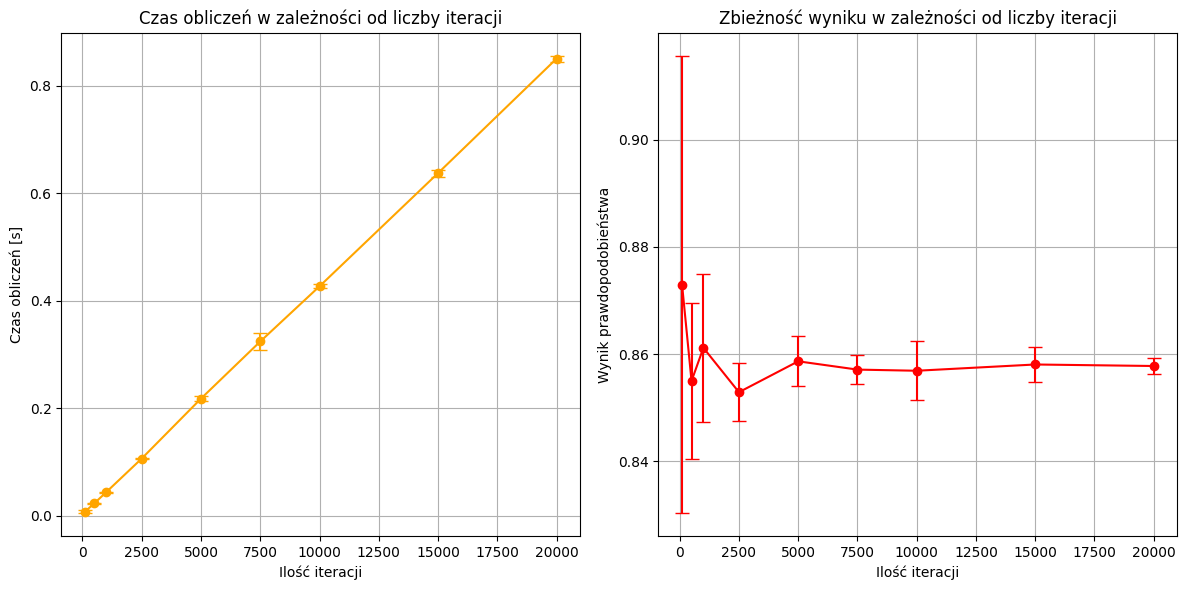

In [72]:
def plot_results(results, timings):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    x = list(timings.keys())
    y = [v[0] for v in timings.values()]
    y_err = [v[1] for v in timings.values()]
    plt.errorbar(x, y, yerr=y_err, fmt='-o', capsize=5, color='orange')
    plt.xlabel('Ilość iteracji')
    plt.ylabel('Czas obliczeń [s]')
    plt.title('Czas obliczeń w zależności od liczby iteracji')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    x = list(results.keys())
    y = [v[0] for v in results.values()]
    y_err = [v[1] for v in results.values()]
    plt.errorbar(x, y, yerr=y_err, fmt='-o', capsize=5, color='red')
    plt.xlabel('Ilość iteracji')
    plt.ylabel('Wynik prawdopodobieństwa')
    plt.title('Zbieżność wyniku w zależności od liczby iteracji')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_results(results, timings)

#### **Wnioski**

Wykresy jasno pokazują, że dla małej ilości iteracji wyniki działania algorytmu są niestabilne, bo występuje duże odchylenie standardowe. Wraz ze wzrostem ilości iteracji wyniki stają się bardziej precyzyjne. Wynik końcowy ok. 0.858 zgadza się wystarczająco blisko z poprzednimi testami. Czas obliczeń wzrasta liniowo wraz ze wzrostem ilości iteracji.

In [45]:
my_net_3 = prepare_net()

query = "B"  
evidence = {"C": "tak", "G": "nie", "L": "nie"}
iteration_list = [100, 500, 1000, 2500, 5000, 7500, 10000, 15000, 20000]
    
results_2, timings_2 = analize(my_net_3, evidence, query, iteration_list, analized_val='silny')

Przeprowadzę też test dla innego polecenia - prawdopodobieństwo silnego bólu, gdy pacjent ma chorobę, ale nie ma gorączki i nie przyjmuje leków.

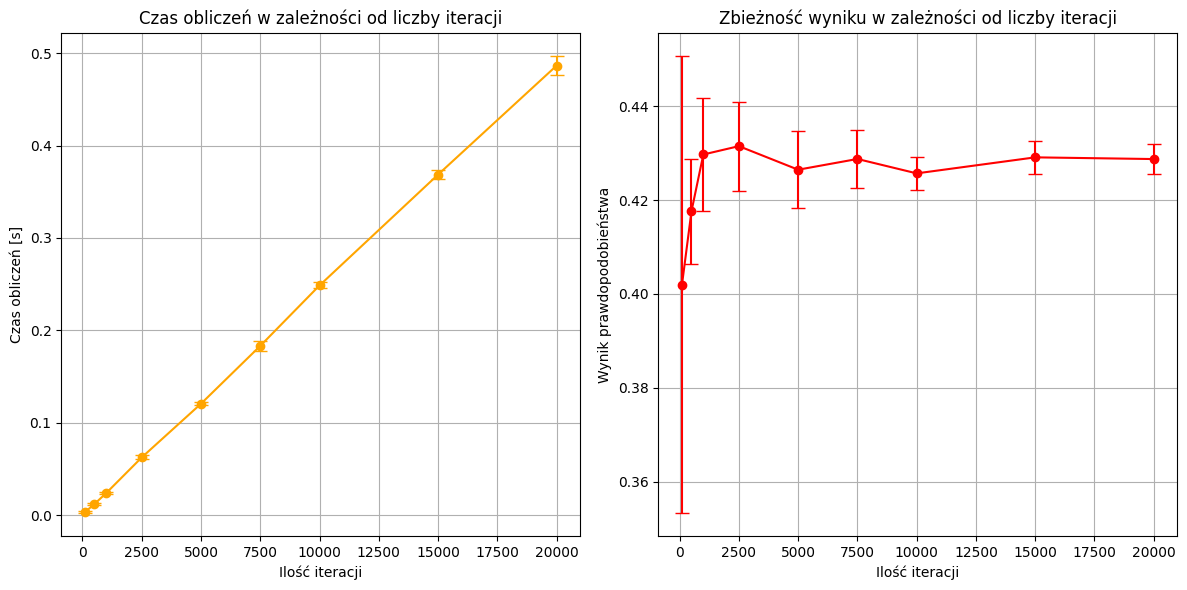

In [46]:
plot_results(results_2, timings_2)

#### **Wnioski**

Ponownie widać wzrost jakości wraz ze zwiększeniem ilości iteracji. Oraz liniowy wzrost czasu obliczeń.